# Netflix Exploratory Data Analysis
## By: Zachary Delk

In [3]:
# Loading and Inspecting
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Downloading and Storing Dataset
working_path = kagglehub.dataset_download("shivamb/netflix-shows")
file_path = working_path + "/netflix_titles.csv"
df = pd.read_csv(file_path)

# Inspecting Data
# print(df.head(3))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


In [4]:
# Step 2: Data Cleaning

# Dealing with missing data
df[df == 'Not Given'] = np.nan

# Removing Uneccessary Keywords in Genre
substring_to_remove = ['TV', 'Shows', 'Movies', '\'']
pattern = "|".join(substring_to_remove)
df['listed_in'] = df['listed_in'].str.replace(pattern, "", regex=True)

# Creating list columns for where there are multiple entries
to_split = ['director', 'cast', 'country', 'listed_in']

df_clean = df.copy()

for col in to_split:
    col_name = col + '_list'
    df_clean[col_name] = df[col].str.split(r',\s*', regex=True).apply(
        lambda x: [i.strip() for i in x] if isinstance(x, list) else None
        )


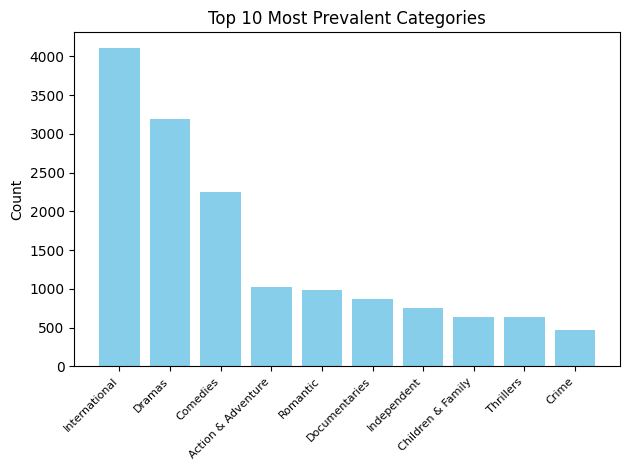

In [5]:
# Q1.What are the most prevalent categories?

# Using the column of lists to make a Category dictionary
cat_dict = {}
for show in df_clean['listed_in_list']:
    for cat in show:
        if cat in cat_dict:
            cat_dict[cat] += 1
        else:
            cat_dict[cat] = 1

# Sorting Dictionary and Looking at 10 Most Prevalent Categories
sorted_cats = sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)
top_10_cats = sorted_cats[:10]
# print(top_10_cats)
categories, counts = zip(*top_10_cats)
plt.bar(x=categories, height=counts, color = 'skyblue')
plt.title('Top 10 Most Prevalent Categories')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()

<Axes: >

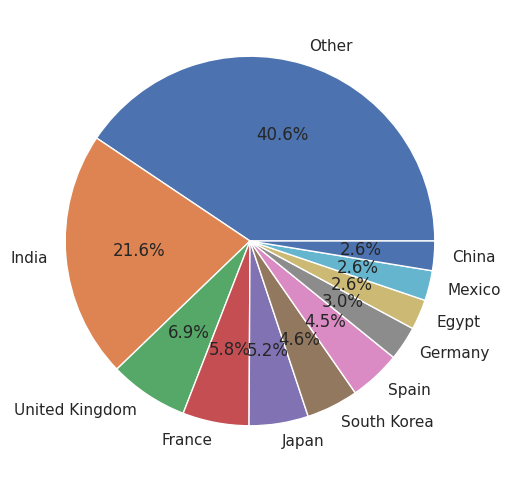

In [19]:
# Looking Deeper into it

# Subset data to just relevant info
# Only worried about entries where 'International' is in the categories
subset_int = df_clean[['country_list', 'listed_in_list', 'type']].dropna()
subset_int = subset_int[subset_int['listed_in_list'].apply(lambda x: 'International' in x)]


# Each country for each observation gets its own row
exploded = subset_int.explode('country_list')

# Getting Counts of Tv Shows and Movies for each country
country_media_df = exploded.groupby(['country_list','type'], observed=True).size().unstack(fill_value=0)

country_media_df['Total'] = country_media_df.sum(axis=1) # Total media for country
cm_sorted = country_media_df.sort_values(by='Total', axis=0, ascending=False) # Sorting by total count

# Dropping US since I live there
cm_sorted = cm_sorted.drop('United States')

ten_place = cm_sorted['Total'].iloc[9] # Count for 10th largest
cm_sorted = cm_sorted.reset_index()
# If below rank 10 grouped to Other
cm_sorted['country_list'] = cm_sorted['country_list'].where(cm_sorted['Total'] >= ten_place, 'Other')

cm_grouped = (
    cm_sorted
    .groupby('country_list')[['Movie', 'TV Show', 'Total']]
    .sum()
    .sort_values(by='Total', ascending=False)
)


cm_grouped.plot.pie(y='Total',label='', legend=False, autopct='%1.1f%%', figsize=(6,6))

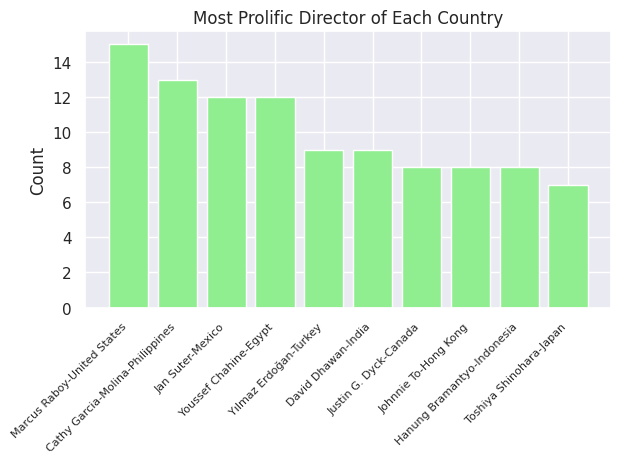

In [80]:
# - Who is/are the most prolific directors for each country?
mask = df_clean['director_list'].notna() & df_clean['country_list'].notna()
directors = df_clean.loc[mask, ['director_list','country_list']].copy()
directors_exploded = directors.explode('director_list').explode('country_list')
director_count = (
    directors_exploded
    .groupby(['director_list','country_list'])
    .size()
    .reset_index(name='count')
)

most_prolific = (
    director_count
    .sort_values('count', ascending=False)
    .groupby('country_list')
    .head(1)
    .reset_index(drop=True)
)
top_10_directors = most_prolific.iloc[:10,:].copy()
top_10_directors['name_country'] = top_10_directors['director_list'] + '-' + top_10_directors['country_list']

plt.bar(x=top_10_directors['name_country'], height=top_10_directors['count'], color='lightgreen')
plt.title('Most Prolific Director of Each Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()

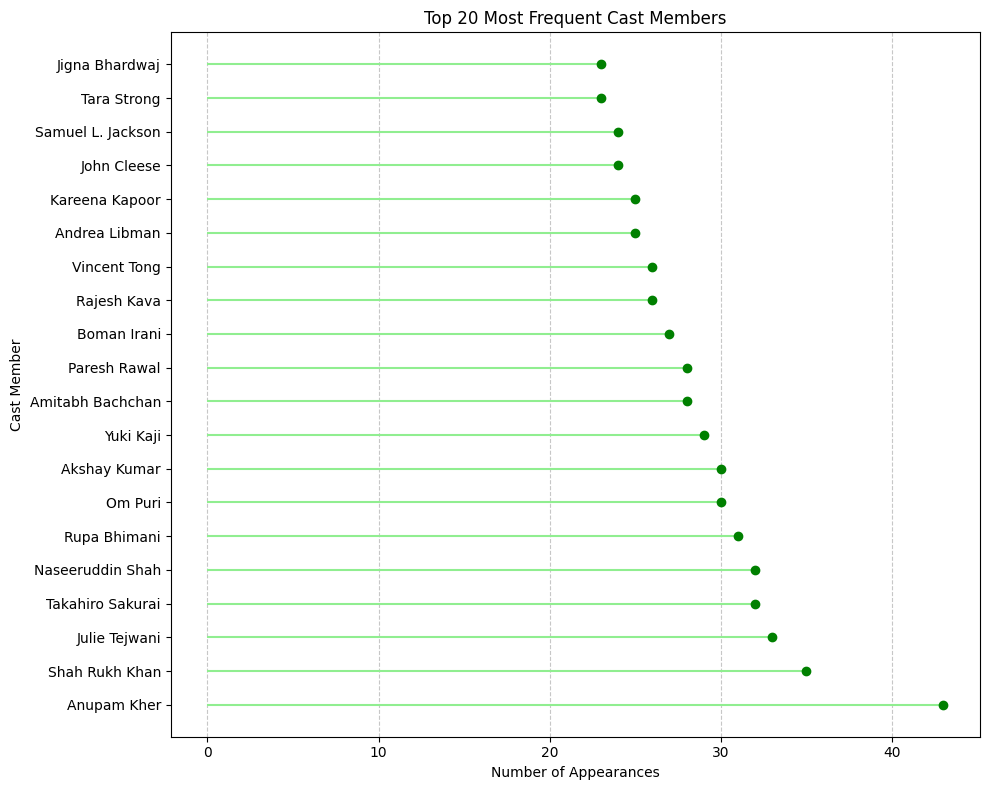

In [8]:
# - Most common cast member?

subset_cast = df_clean['cast_list'].dropna()

cast_exploded = subset_cast.explode('cast_list')
cast_count = cast_exploded.value_counts().reset_index()

top_n = 20
top_cast = cast_count.head(top_n)

plt.figure(figsize=(10,8))
plt.hlines(y=top_cast['cast_list'], xmin=0, xmax=top_cast['count'], color='lightgreen')
plt.plot(top_cast['count'], top_cast['cast_list'], 'o', color='green')

plt.xlabel('Number of Appearances')
plt.ylabel('Cast Member')
plt.title(f'Top {top_n} Most Frequent Cast Members')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

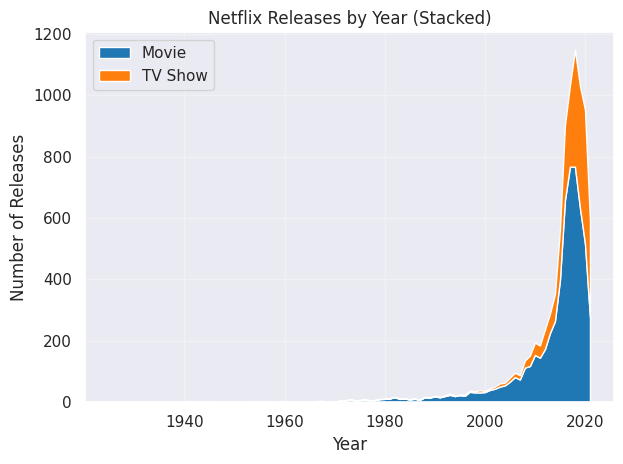

In [9]:
import seaborn as sns

sns.set_theme()
# - Amount of releases by year split by TV Show or Movie
subset_time = df[['type','release_year']].dropna()
release_group = subset_time.groupby(['release_year','type']).size().unstack(fill_value = 0)
release_group_counts = release_group.sort_index()

plt.stackplot(release_group_counts.index,
              release_group_counts['Movie'],
              release_group_counts['TV Show'],
              labels=['Movie', 'TV Show'],
              colors=['#1f77b4', '#ff7f0e']
              )

plt.legend(loc='upper left')
plt.title('Netflix Releases by Year (Stacked)')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
# - How long are the movies on average, by genre or by country?
# Subset to only movies
# Explode by country and genre
df_movie = df_clean[df_clean['type'] == 'Movie'].copy()

df_movie['duration'] = df_movie['duration'].str.replace('min', "")
df_movie['duration_int'] = df_movie['duration'].astype('Int64')

movie_country = df_movie.explode('country_list').dropna()

mean_duration_country = (
    movie_country
    .dropna(subset=['country_list', 'duration_int'])  # drop rows with missing country or duration
    .groupby('country_list')['duration_int']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
mean_duration_country.columns = ['Country', 'Avg. Duration']
mean_duration_country['Avg. Duration'] = mean_duration_country['Avg. Duration'].round(1)

mean_duration_country.iloc[:10,:].style.set_caption("Top 10 Countries by Average Movie Duration") \
     .format({'Avg. Duration': '{:.1f}'}) \
     .hide(axis='index') 


Country,Avg. Duration
Liechtenstein,200.0
Montenegro,157.0
Soviet Union,156.7
Morocco,147.4
Bahamas,145.0
Cameroon,143.0
Malta,135.5
Pakistan,127.9
India,127.3
Ethiopia,125.0


In [76]:
# mean_duration
movie_genre = df_movie.explode('listed_in_list')

mean_duration_genre = (
    movie_genre
    .dropna(subset=['listed_in_list', 'duration_int'])  # drop rows with missing genre or duration
    .groupby('listed_in_list')['duration_int']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

mean_duration_genre.columns = ['Genre', 'Avg. Duration']
mean_duration_genre['Avg. Duration'] = mean_duration_genre['Avg. Duration'].round(1)

mean_duration_genre.iloc[:10,:].style.set_caption("Top 10 Countries by Average Movie Duration") \
     .format({'Avg. Duration': '{:.1f}'}) \
     .hide(axis='index') 

Genre,Avg. Duration
Classic,118.6
Action & Adventure,113.5
Dramas,113.1
Romantic,110.6
International,110.3
Thrillers,107.2
Music & Musicals,106.1
Sci-Fi & Fantasy,106.0
Faith & Spirituality,105.6
Cult,104.5
